# Deep Learning class exercise list 1

## Question 1

* ### Generating Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [2]:
def generate_data(data_size, train_val_split = 0.1):
    X = np.zeros((data_size, 3),dtype=np.float128)
    y = np.zeros((data_size, 8),dtype=np.float128)
    for i in range(data_size):
        arr = np.random.randint(0, 2, 3) + np.random.uniform(-0.1,0.1, 3)
        X[i] = np.round(arr,4)
        y[i][int(round(arr[0]) * 4 + round(arr[1]) * 2+ round(arr[2]))] = 1
    
    val_split = round(data_size * (1 - train_val_split))

    X_train, y_train = X[:val_split].T, y[:val_split].T
    X_val, y_val = X[val_split:].T, y[val_split:].T
    return X_train, X_val, y_train, y_val

In [3]:
def generate_data2(data_size, train_val_split = 0.1):
    X = np.zeros((data_size, 1))
    y = np.zeros((data_size, 1))
    for i in range(data_size):
        arr = np.random.randint(0, 2, 1) + np.random.uniform(-0.1,0.1, 1)
        X[i] = np.round(arr,4)
        y[i] = int(np.round(X[i]))
    
#     val_split = round(data_size * (1 - train_val_split))
#     X_train, y_train = X[:val_split].T, y[:val_split].T
#     X_val, y_val = X[val_split:].T, y[val_split:].T
    return X.T, y.T

In [4]:
X_train, X_val, y_train, y_val = generate_data(20)

* ### MLP

In [5]:
def sigmoid(value):
    return 1/(1 + np.exp(-value))

def sigmoid_derivative(value):
    return sigmoid(value) * (1 - sigmoid(value))

In [38]:
def softmax(value):
    expA = np.exp(value.T - np.max(value.T, axis=1, keepdims=True))
    return (expA / expA.sum(axis=1, keepdims=True)).T

In [39]:
def relu(value):
    return np.maximum(value, 0)

def relu_derivative(value):
    value[relu(value) <=0] = 0
    return value

In [104]:
class MLP():
    def __init__(self):
        """
        Initializes your class:
            parameters : dictionary of parameters, which will store W and b through propagation.
            cache : dictionary of cache, which will be responsible for storing A and Z during the propagation.
            grads: dictionary of gradients, which will store all gradients computed during backprop.
        
        Args:
            No arguments taken.
        return:
            No return.
        """
        
        self.parameters = {}
        self.cache = {}
        self.grads = {}

    def fit(self, X_train, y_train, hidden=relu, output=softmax):
        """
        Args : 
            X_train = input data of shape (n_x, number_of_examples).
            y_train = label vector of shape (n_y, number_of_examples).
        """
        self.X_train = X_train
        self.y_train = y_train
        self.m = X_train.shape[1]
        self.hidden = hidden # function passed as argument to be used on hidden layers
        self.output = output # function passed as argument to be used on output layers

    def initialize_parameters(self, dims):
        """
        Args:
            dims = dimensions of the network.
            
            Example:
                dims = [3,3,8]
                
                A network with input size = 3, hidden layer = 3 and output layer = 8.
                
                The first dimension on the list must always be the length of each example.
                The last dimension on the list must always be the length of each output example.
                
                In a case where X_train shape = (3, 4500) and y_train shape = (8, 4500), 4500 in
                each shape represents the number of examples.
                
                dims = [3, 8]
        Return:
            parameters : a dictionary containing all weights and biases intialized
                
        """
        self.L = len(dims)
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.random.randn(dims[l], dims[l-1])
            self.parameters["b" + str(l)] = np.zeros((dims[l], 1))
        return self.parameters
    
    def propagate(self, X):
        """
        Does the forward propagation of the network
        """
        A_prev = X
        self.cache[f"A{0}"] = A_prev
        for l in range(1, self.L):
            
            Z = np.dot(self.parameters[f"W{l}"], A_prev) + self.parameters[f"b{l}"]

            if l == self.L - 1:
                A = self.output(Z)
            else:
                A = self.hidden(Z)

            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A
            
            A_prev = A
        
        self.y_hat = A

    def predict(self, X):
        """
        Predicts the value using the propagate function
        
        Args:
            X : data to be used on prediction
        Return:
            y_hat : data predicted
        """
        self.propagate(X)
        return self.y_hat
    
    def error(self):
        pred = self.y_hat.T
        real = self.y_train.T
        n_samples = real.shape[0]
        logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
        loss = np.sum(logp)/(n_samples)
        return loss

    def cross_entropy(self):
        res = self.y_hat - self.y_train
        return res

    def compute_grads(self):
        cross_entropy_value = self.cross_entropy()
        
        dZ = cross_entropy_value

        self.grads[f"dW{self.L - 1}"] = 1/self.m * (np.dot(dZ, self.cache[f"A{self.L - 2}"].T))
        self.grads[f"db{self.L - 1}"] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)

        for l in reversed(range(1, self.L - 1)):
            self.grads[f"dA_prev{l}"] = np.dot(self.parameters[f"W{l + 1}"].T,dZ)
            dZ = self.grads[f"dA_prev{l}"] * relu_derivative(self.cache[f"Z{l}"])
            self.grads[f"dW{l}"] = 1/self.m * (np.dot(dZ, self.cache[f"A{l - 1}"].T))
            self.grads[f"db{l}"] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)
    
    def backprop(self, learning_rate = 0.01):
        self.learning_rate = learning_rate
        for l in reversed(range(1, self.L)):
            #print(l)
            self.parameters["W"+str(l)] -= self.learning_rate * (self.grads[f"dW{l}"])
            self.parameters["b"+str(l)] -= self.learning_rate * (self.grads[f"db{l}"])

    def compute_cost(self):
        logprods = np.dot(self.y_train, np.log(self.y_hat).T) + np.dot((1-self.y_train), np.log(1- self.y_hat).T)
        cost = -1/self.m*np.sum(logprods)
        
        return np.sum(self.loss)/self.m

    def train(self, dims, learning_rate = 0.01, iterations = 1000):
        printing_interval = round(iterations * 0.01)
        self.initialize_parameters(dims)
        costs = []
        for i in range(iterations):
            self.propagate(self.X_train)
            loss = self.error()
            if i % printing_interval == 0:
                print(f"epoch {i} : {loss}")
            costs.append(loss)
            self.compute_grads()
            self.backprop(learning_rate = learning_rate)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

In [105]:
X_train, X_val , y_train, y_val = generate_data(50000)

In [106]:
mlp = MLP()

In [107]:
mlp.fit(X_train, y_train)

epoch 0 : 5.409663895024497
epoch 50 : 1.7647741502107657
epoch 100 : 1.4084206010963762
epoch 150 : 1.262580037681157
epoch 200 : 1.148467679422792
epoch 250 : 0.8689795546763687
epoch 300 : 0.7613747982964134
epoch 350 : 0.8103147143737719
epoch 400 : 0.5382307816686325
epoch 450 : 0.4744851095039884
epoch 500 : 0.37326934338671713
epoch 550 : 0.25797460717735354
epoch 600 : 3.2408520700512815
epoch 650 : 1.2519175995536729
epoch 700 : 1.1243481349584465
epoch 750 : 1.038295111338606
epoch 800 : 0.9797057287973799
epoch 850 : 0.9403633977988954
epoch 900 : 0.9093414971448963
epoch 950 : 0.8814512223023158
epoch 1000 : 0.8551927538998849
epoch 1050 : 0.8302075974585025
epoch 1100 : 0.8064778567448194
epoch 1150 : 0.7840413288097615
epoch 1200 : 0.7630685898000124
epoch 1250 : 0.7437360291596895
epoch 1300 : 0.7260036993419747
epoch 1350 : 0.709685307426376
epoch 1400 : 0.6943634794536958
epoch 1450 : 0.6784453092469277
epoch 1500 : 0.6385968049551156
epoch 1550 : 0.583925099725276
epo

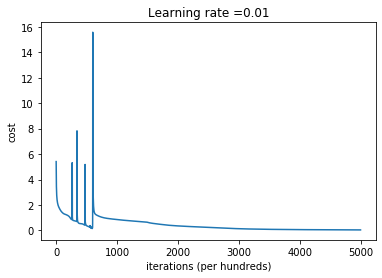

In [117]:
mlp.train([X_train.shape[0], 10, 10, y_train.shape[0]], iterations=5000, learning_rate=0.01)

In [109]:
y_pred = mlp.predict(X_val)

In [110]:
y_pred.shape

(8, 5000)

In [111]:
np.argmax(y_pred.T, axis = 1)

array([6, 1, 0, ..., 2, 7, 4])

In [112]:
np.argmax(y_val.T, axis = 1)

array([6, 1, 0, ..., 2, 7, 4])

## opa

In [113]:
from sklearn.metrics import accuracy_score

In [114]:
accuracy_score(np.argmax(y_pred.T, axis = 1), np.argmax(y_val.T, axis = 1))

1.0